# Classifying Disaster Tweets with RNN's

by Kris Smith

## Problem Statement

This notebook is tackling a [Kaggle competition](https://www.kaggle.com/competitions/nlp-getting-started/overview) wherein the problem is defined in their own words as:

### Competition Description

*Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).*

*But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:*

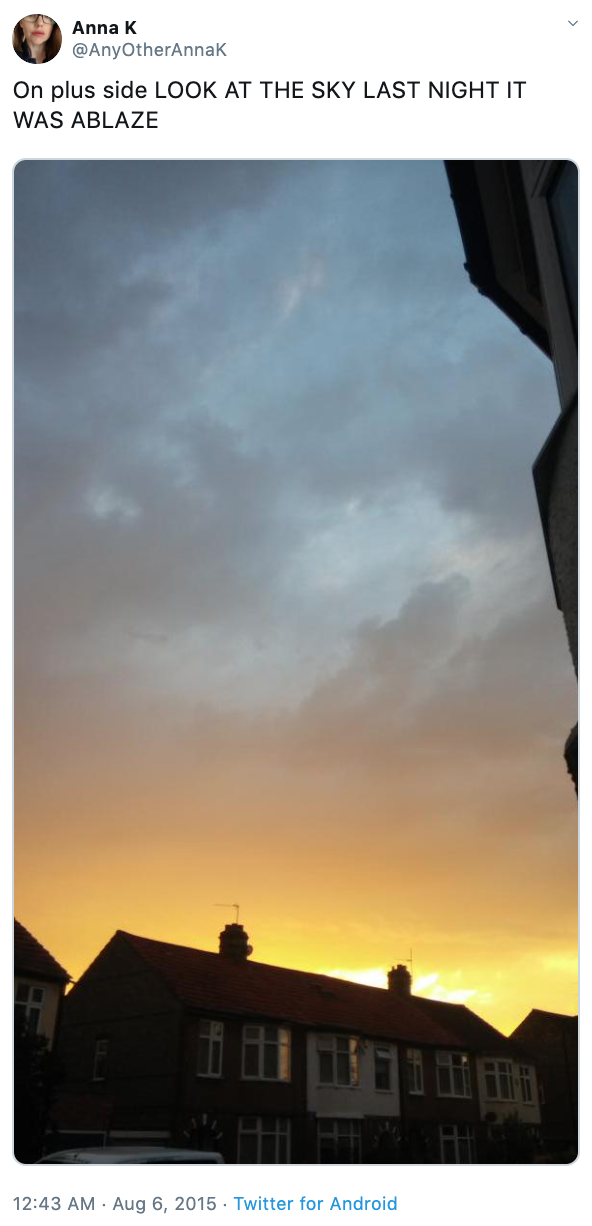

*The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.*

*In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running.*

**Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.**

*Acknowledgments
This dataset was created by the company figure-eight and originally shared on their ‘Data For Everyone’ website here.*

*Tweet source: https://twitter.com/AnyOtherAnnaK/status/629195955506708480*


### Evaluation

***Competition metric is the F1 score:***

$$
F1 = 2*\frac{precision*recall}{precision+recall}
$$

***where:***

$$
precision = \frac{TP}{TP+FP}
$$

***and:***

$$
recall = \frac{TP}{TP+FN}
$$

***put more simply:***

***True Positive [TP] = your prediction is 1, and the ground truth is also 1 - you predicted a positive and that's true!***

***False Positive [FP] = your prediction is 1, and the ground truth is 0 - you predicted a positive, and that's false.***

***False Negative [FN] = your prediction is 0, and the ground truth is 1 - you predicted a negative, and that's false.***

---
# EDA

## Import Libraries

In [1]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import os
import gc
import re
import string
import operator
from collections import defaultdict
import spacy
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize

nlp = spacy.load('en_core_web_lg')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

## Set seed for reproducible results
SEED = 112358

# import numpy as np
# import pandas as pd
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

# import matplotlib.pyplot as plt
# import seaborn as sns

# import tokenization
# from wordcloud import STOPWORDS

# from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
# from sklearn.metrics import precision_score, recall_score, f1_score

# import tensorflow as tf
# import tensorflow_hub as hub
# from tensorflow import keras
# from tensorflow.keras.optimizers import SGD, Adam
# from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

# SEED = 1337

## Import and Inspect Train and Test Sets

In [2]:
train_path = '../input/nlp-getting-started/train.csv'
test_path = '../input/nlp-getting-started/test.csv'

# Get the size of the .csv files
train_size = os.path.getsize(train_path)
test_size = os.path.getsize(test_path)

# Convert the file size to MiB
train_size = round((train_size / 1024**2), 2)
test_size = round((test_size / 1024**2), 2)

print(f"Train File size: {train_size} MiB")
print(f"Test File size: {test_size} MiB")

df_train = pd.read_csv(train_path, dtype={'id': np.int16, 'target': np.int8})
df_test  = pd.read_csv(test_path,  dtype={'id': np.int16})

print('Training Data Shape = {}'.format(df_train.shape))
print('Test Data Shape = {}'.format(df_test.shape))

Train File size: 0.94 MiB
Test File size: 0.4 MiB
Training Data Shape = (7613, 5)
Test Data Shape = (3263, 4)


***The data seems to be quite minimal which makes sense. This competition on Kaggle was a learning competition and as such had no prize money or actual business attached to it. The means the dataset we are using is somewhat of a 'toy' dataset.***

## Inspect Column Data Types and Counts

In [3]:
print('Training set info')
print('\n')
df_train.info();
print('\n\n\n')
print('Testing set info')
print('\n')
df_test.info()

Training set info


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int16 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int8  
dtypes: int16(1), int8(1), object(3)
memory usage: 200.9+ KB




Testing set info


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int16 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int16(1), object(3)
memory usage: 83.0+ KB


***We can see that the id and target columns are numerical and the keyword, location, and text columns are object type(string). Lets see what the data actually looks like.***

In [4]:
df_train.sample(7, random_state=SEED)

,id,keyword,location,text,target
4149,5898,harm,Kansas City,@dinallyhot Love what you picked! We're playin...,0
2988,4295,drowning,NaN,@Homukami Only URs and SRs matter Rs you'll be...,0
6071,8673,sinkhole,Texas af,Damn that sinkhole on sunset????,1
6720,9627,thunderstorm,"Asheville, NC",iNWS Alert SPSGSP from 8/5/2015 10:40 PM to 11...,1
6656,9539,terrorist,MAD as Hell,RT AbbsWinston: #Zionist #Terrorist kidnapped ...,1
1806,2594,crash,NaN,I see dat we liable to fuck up and crash ????,0
7240,10368,weapons,"Vermont, USA",I think this is my plan for retirement. Check ...,0


## Class Distributions

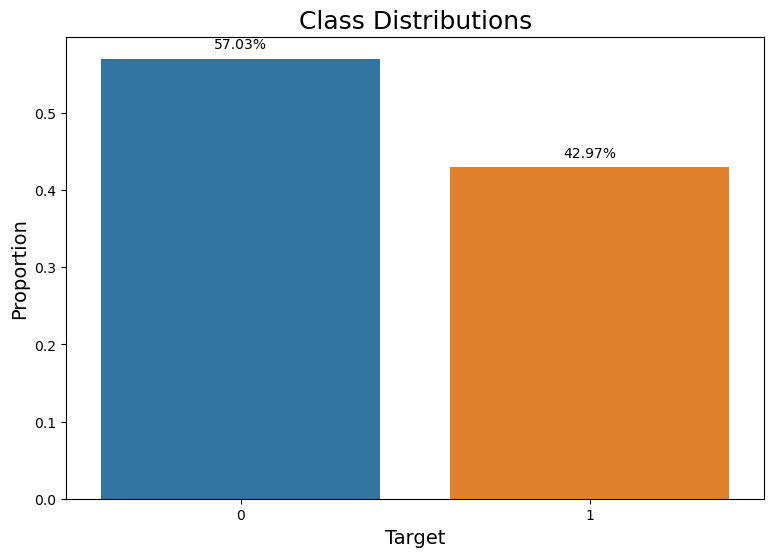

In [5]:
# Calculate the proportions
target_counts = df_train['target'].value_counts(normalize=True).reset_index()

plt.figure(figsize=(9,6))
ax = sns.barplot(data=target_counts, x='index', y='target')

# Add the annotations
for p in ax.patches:
    ax.annotate('{:.2%}'.format(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points')

plt.title('Class Distributions', fontsize=18) 
plt.xlabel('Target', fontsize=14)     
plt.ylabel('Proportion', fontsize=14) 
plt.show()

***So we have a slight class imbalance. At this point I am not sure I wish to do anything about it. We shall see if it may affect any outcomes with model performance.***

## Feature Engineering

### Create NER based features from text column

In [21]:
df_train['num_verbs'] = df_train['text'].apply(lambda row: sum(1 for word, pos in pos_tag(word_tokenize(row)) if pos.startswith('VB')))
df_test['num_verbs']  =  df_test['text'].apply(lambda row: sum(1 for word, pos in pos_tag(word_tokenize(row)) if pos.startswith('VB')))

#### Create Verb Count Feature
***Does negative class tweets or positive class tweets contain more verbs than the other?***

In [19]:
print(f"Average number of verbs in negative class tweets = {round(df_train[df_train['target']==0]['num_verbs'].mean(), 3)}")
print(f"Average number of verbs in positive class tweets = {round(df_train[df_train['target']==1]['num_verbs'].mean(), 3)}")
print('\n')
print(f"Negative class tweets on average contain {round(1-(round(df_train[df_train['target']==1]['num_verbs'].mean(), 3)/round(df_train[df_train['target']==0]['num_verbs'].mean(), 3)), 2)}% more verbs.")

Average number of verbs in negative class tweets = 2.385
Average number of verbs in positive class tweets = 2.055


Negative class tweets on average contain 0.14% more verbs.


***It appears that negative class tweets contain more verbs on average than positive class tweets:***

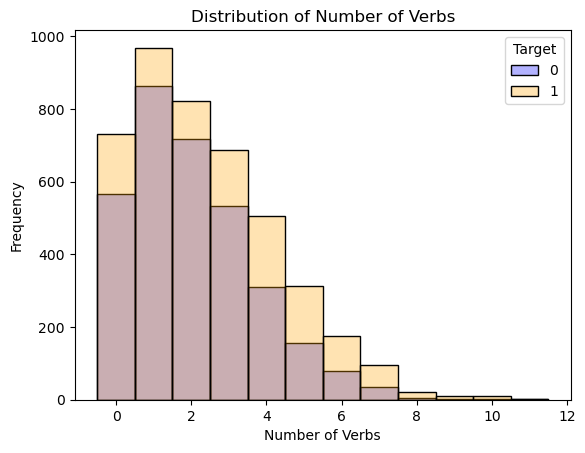

In [71]:
pos, neg = df_train[df_train['target']==1], df_train[df_train['target']==0]

sns.histplot(data=pos, x='num_verbs', discrete=True, multiple="stack", alpha=0.3, color='blue')
sns.histplot(data=neg, x='num_verbs', discrete=True, multiple="stack", alpha=0.3, color='orange')

plt.title('Distribution of Number of Verbs') 
plt.xlabel('Number of Verbs')  
plt.ylabel('Frequency')  
plt.legend(title='Target', labels=['0', '1'])  
plt.show()

#### Create Named Entity Count Feature

In [22]:
df_train['num_entities'] = df_train['text'].apply(lambda row: len([ent for ent in nlp(row).ents]))
df_test['num_entities']  =  df_test['text'].apply(lambda row: len([ent for ent in nlp(row).ents]))

***Does negative class tweets or positive class tweets contain more named entities than the other?***

In [29]:
print(f"Average number of named entities in negative class tweets = {round(df_train[df_train['target']==0]['num_entities'].mean(), 3)}")
print(f"Average number of named entities in positive class tweets = {round(df_train[df_train['target']==1]['num_entities'].mean(), 3)}")
print('\n')
print(f"Positive class tweets on average contain {round(1-(round(df_train[df_train['target']==0]['num_entities'].mean(), 3)/round(df_train[df_train['target']==1]['num_entities'].mean(), 3)), 2)}% more named entities.")

Average number of named entities in negative class tweets = 1.24
Average number of named entities in positive class tweets = 1.96


Positive class tweets on average contain 0.37% more named entities.


***It appears that positive class tweets contain more named entities on average than negative class tweets:***

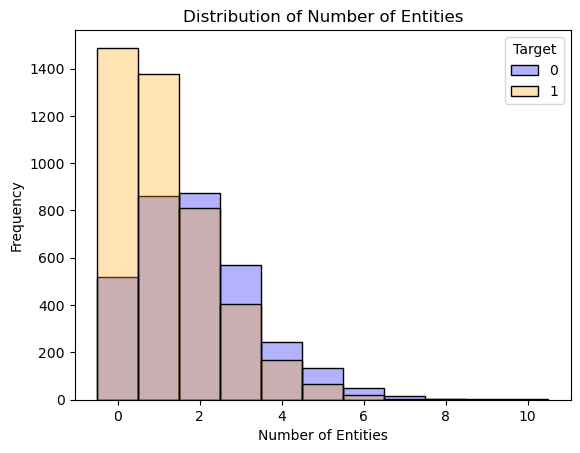

In [70]:
pos, neg = df_train[df_train['target']==1], df_train[df_train['target']==0]

sns.histplot(data=pos, x='num_entities', discrete=True, multiple="stack", alpha=0.3, color='blue')
sns.histplot(data=neg, x='num_entities', discrete=True, multiple="stack", alpha=0.3, color='orange')

plt.title('Distribution of Number of Entities') 
plt.xlabel('Number of Entities')  
plt.ylabel('Frequency')  
plt.legend(title='Target', labels=['0', '1'])  
plt.show()

### Create Word Count Feature

In [23]:
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count']  =  df_test['text'].apply(lambda x: len(str(x).split()))

***Does positive class or negative class contain more words on average?***

In [32]:
print(f"Average number of words in negative class tweets = {round(df_train[df_train['target']==0]['word_count'].mean(), 3)}")
print(f"Average number of words in positive class tweets = {round(df_train[df_train['target']==1]['word_count'].mean(), 3)}")
print('\n')
print(f"Positive class tweets on average contain {round(1-(round(df_train[df_train['target']==0]['word_count'].mean(), 3)/round(df_train[df_train['target']==1]['word_count'].mean(), 3)), 2)}% more words.")

Average number of words in negative class tweets = 14.705
Average number of words in positive class tweets = 15.168


Positive class tweets on average contain 0.03% more words.


***The difference in length in words on average for classes seems negligible.***

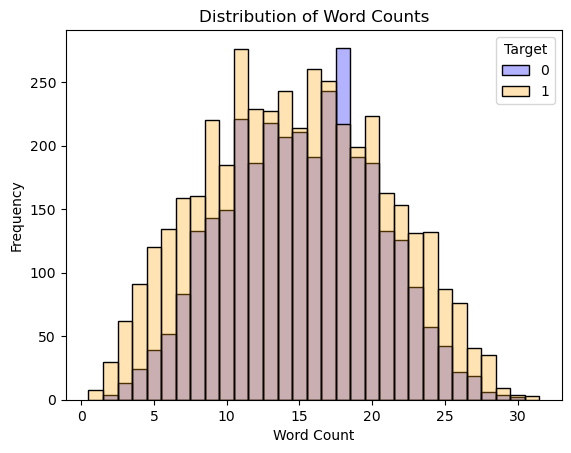

In [69]:
pos, neg = df_train[df_train['target']==1], df_train[df_train['target']==0]

sns.histplot(data=pos, x='word_count', discrete=True, multiple="stack", alpha=0.3, color='blue')
sns.histplot(data=neg, x='word_count', discrete=True, multiple="stack", alpha=0.3, color='orange')

plt.title('Distribution of Word Counts') 
plt.xlabel('Word Count')  
plt.ylabel('Frequency')  
plt.legend(title='Target', labels=['0', '1'])  
plt.show()